Linear Regression Assignment

In [ ]:
## Import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

import torch
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

In [ ]:
## import model related libraries

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from math import pi

In [ ]:

# RMSLE function definition
#RMSLE = sqrt( (1/n) * Σ (log(pred+1) - log(actual+1))² ) 

def rmsle(y_true, y_pred):
    y_pred = np.where(y_pred<0, 0, y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

In [ ]:
# importing data to dataframe using pandas  
train = pd.read_csv("bike_train.csv")
test = pd.read_csv("bike_test.csv")

In [ ]:
# Display the shape of the dataset
print(train.shape)

In [ ]:
# Display the first 5 rows of the training dataset
train.head(5)

In [ ]:
print (train.info()) #2.4 Summary of  Training data set

In [ ]:
print (train.describe()) #2.5 Statistical Summary of all numerical attributes

Q1. Examine dataset size, missing values, and feature types. 
answer : no missing value ,  categorical feature are season, holiday, workingday, weather & continuous variable are temp, atemp, humidity, windspeed
Q2. Visualize relationships between key features and the target variable (count).

Q3: Suggest which variables are likely to be most informative.
Holidays and working day plays important in categorical data
 

In [ ]:
#visualization of data is kept standlone for better readability
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_df = pd.read_csv('bike_train.csv')

# Convert datetime column to datetime type and extract hour and month for temporal analysis
train_df['datetime'] = pd.to_datetime(train_df['datetime'], format='%d/%m/%y %H:%M')
train_df['hour'] = train_df['datetime'].dt.hour
train_df['month'] = train_df['datetime'].dt.month

# Set plotting style
sns.set_style('whitegrid')

# 1. Histograms for continuous features and target
continuous_features = ['temp', 'atemp', 'humidity', 'windspeed', 'count']
train_df[continuous_features].hist(bins=30, figsize=(12, 8))
plt.suptitle('Distribution of Continuous Features and Target')
plt.show()

# 2. Boxplots of count by categorical features
categorical_features = ['season', 'holiday', 'workingday', 'weather']
plt.figure(figsize=(14, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=feature, y='count', data=train_df)
    plt.title(f'Count by {feature.capitalize()}')
plt.tight_layout()
plt.show()

# 3. Scatter plots for continuous features vs count
plt.figure(figsize=(15, 5))
for i, feature in enumerate(['temp', 'humidity', 'windspeed'], 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=feature, y='count', data=train_df, alpha=0.3)
    plt.title(f'Count vs {feature.capitalize()}')
plt.tight_layout()
plt.show()

# 4. Line plot for average count by hour of the day
plt.figure(figsize=(8, 5))
hourly_counts = train_df.groupby('hour')['count'].mean()
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values)
plt.title('Average Bike Count by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Average Count')
plt.show()

# 5. Correlation heatmap for continuous variables
plt.figure(figsize=(8, 6))
corr = train_df[continuous_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Continuous Features')
plt.show()

# 6. Pairplot of key features and count (sample for speed)
sns.pairplot(train_df.sample(500), vars=['temp', 'humidity', 'windspeed', 'count'])
plt.suptitle('Pairplot of Selected Features and Count', y=1.02)
plt.show()


In [ ]:
# Your dataset uses DD/MM/YY HH:MM format, so dayfirst=True is appropriate
train['datetime_parsed'] = pd.to_datetime(
    train['datetime'], 
    dayfirst=True, 
    errors='coerce'
)

test['datetime_parsed'] = pd.to_datetime(
    test['datetime'], 
    dayfirst=True, 
    errors='coerce'
)
#  Extract datetime features
def add_datetime_features(df):
    # Basic time units
    df['hour'] = df['datetime_parsed'].dt.hour
    df['day'] = df['datetime_parsed'].dt.day
    df['month'] = df['datetime_parsed'].dt.month
    df['year'] = df['datetime_parsed'].dt.year
    
    # Monday = 0 ... Sunday = 6
    df['weekday'] = df['datetime_parsed'].dt.weekday
    
    # Weekend flag
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    
    return df


# Apply for both train and test
train = add_datetime_features(train)
test = add_datetime_features(test)

In [ ]:
#  causal and registered columns are not present in test set, so drop them from train set , also target is to get predicated count , 
# hence dropping these columns will avoid data leakage  
for c in ['casual','registered']:
    if c in train.columns:
        train = train.drop(columns=[c])

In [ ]:

#  Target & base features
y = train['count']
X = train.drop(columns=['count','datetime'])

In [ ]:

# Cyclical encoding of time features
def cyclical_encode(series, period, prefix):
    radians = 2 * np.pi * series / period
    return pd.DataFrame({
        f'{prefix}_sin': np.sin(radians),
        f'{prefix}_cos': np.cos(radians)
    })

# Apply cyclical enc
X_cyc = pd.concat([
    cyclical_encode(X['hour'], 24, 'hour'),
    cyclical_encode(X['month'], 12, 'month'),
    cyclical_encode(X['weekday'], 7, 'weekday')], axis=1)

X_model_fe = X.drop(columns=['hour','day','month','weekday']).reset_index(drop=True)
X_model_fe = pd.concat([X_model_fe, X_cyc.reset_index(drop=True)], axis=1)

# same for test
test_model = test.drop(columns=['datetime']).copy()
test_cyc = pd.concat([
    cyclical_encode(test_model['hour'], 24, 'hour'),
    cyclical_encode(test_model['month'], 12, 'month'),
    cyclical_encode(test_model['weekday'], 7, 'weekday')], axis=1)
test_model = test_model.drop(columns=['hour','day','month','weekday']).reset_index(drop=True)
test_model = pd.concat([test_model, test_cyc.reset_index(drop=True)], axis=1)

In [ ]:
# model feature columns
numeric_cols = ['temp','atemp','humidity','windspeed','year','day']
cyc_cols = ['hour_sin','hour_cos','month_sin','month_cos','weekday_sin','weekday_cos']
cat_cols = ['season','weather','holiday','workingday','is_weekend']

In [ ]:

# Ensure expected columns exist
for col in numeric_cols + cyc_cols + cat_cols:
    if col not in X_model_fe.columns:
        if col in cyc_cols: X_model_fe[col] = 0.0
        elif col in numeric_cols: X_model_fe[col] = X_model_fe[col] if col in X_model_fe.columns else 0.0
        else: X_model_fe[col] = 0
    if col not in test_model.columns:
        test_model[col] = 0

In [ ]:
# Preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols + cyc_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

In [ ]:
# Split the data into training and validation sets
#randoem_state=42 for reproducibility
#test_size=0.2 means 20% data will be used for validation
#Q5. Split data into training and validation sets and build a simple Linear Regression model.
X_train, X_val, y_train, y_val = train_test_split(X_model_fe, y, test_size=0.2, random_state=42)

In [ ]:
#liner regression , ridge regression , random forest and gradient boosting models
#Q6. To improve model performance, you may try to different models and tune hyperparameters.:

models = {
    'Linear': Pipeline([('pre', preprocessor), ('model', LinearRegression())]),
    'Ridge': Pipeline([('pre', preprocessor), ('model', RidgeCV(alphas=[0.1,1.0,10.0]))]),
    'Polynomial Regression (Degree 2)': Pipeline([
        ('pre', preprocessor),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('model', LinearRegression())
    ]),
    'Lasso Polynomial Regression': Pipeline([
        ('pre', preprocessor),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
  
        ('model', Lasso(alpha=0.001))
    ]),
    'RandomForest': Pipeline([('pre', preprocessor), ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))]),
    'GradientBoosting': Pipeline([('pre', preprocessor), ('model', GradientBoostingRegressor(n_estimators=200, random_state=42))])
}

In [ ]:
#Q7. Summarize all results (of different models tried out) in one table (RMSLE, key observations).
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    print(name, "RMSLE:", rmsle(y_val, preds))

In [ ]:
#based on 
final_pipe = Pipeline([('pre', preprocessor), ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])
final_pipe.fit(X_model_fe, y)
test_preds = final_pipe.predict(test_model[numeric_cols + cyc_cols + cat_cols])
test_preds = np.where(test_preds < 0, 0, test_preds)
test_preds_rounded = np.round(test_preds).astype(int)

In [ ]:
# output submission file
submission_out = "submission.csv"  

In [ ]:
submission = pd.DataFrame({'datetime': test['datetime'], 'count_predicted': test_preds_rounded})
submission.to_csv(submission_out, index=False)
print("Saved submission to:", submission_out)

Q7. Summarize all results
Modelname	                          RMSLE	                        Observations
Liner Regression 	                     1.12	    Baseline linear, cannot capture nonlinear or time effects
Ridge	                                 1.11	    small improvement, regularization reduces overfit slightly
Polynomial Regression (Degree 2)	     1.23	    Unstable, tends to overfit, sensitive to feature scaling
Lasso Polynomial Regression 	         1.23	    Better than plain polynomial, regularization helps but still unstable
RandomForest 	                         0.39	    Best model; captures nonlinearity, interactions, and categorical splits
Gradient Boosting	                     0.83	    Reasonably good for nonlinearity, less robust to noise



In [ ]:
## Q8. Plot residuals for the best model.
residuals = y_val- preds

plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.title('Residuals Histogram - Best Model')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Q9 .Explain why the winning model performs better.

The winning model, Random Forest, performs better because it can capture complex nonlinear relationships and interactions among features that simpler models like linear regression cannot. Unlike linear models, which assume additive and independent effects for each feature, Random Forest aggregates multiple decision trees that split the data based on feature values, allowing it to model arbitrary interactions between numeric and categorical variables

Q10: Why does RMSLE penalize under-predictions more gently than RMSE?

RMSLE uses logarithmic errors, so it reduces the penalty when a predicted value is less than the true value (especially for large true values), making it less sensitive to large under-predictions compared to RMSE, which squares all errors equally.

Q11: What are the trade-offs between model simplicity and predictive power?

Simpler models (like linear regression) are easier to interpret and less likely to overfit, but may miss nonlinear patterns and feature interactions. More complex models (e.g., Random Forest) potentially capture more data structure at the cost of explainability and risk of overfitting if not well-tuned.


Q12: Why can’t Linear Regression alone capture time-of-day effects effectively?

Linear regression cannot represent cyclic or periodic patterns (e.g., rush hours, night use) because it assumes additive and linear feature effects. Time-of-day effects are typically nonlinear and cyclical, requiring either feature engineering (cyclical encoding) or more flexible models to represent accurately.


#TransformedTargetRegressor  wrapping the Gradient Boosting model for log-transform of target and the  GridSearchCV  hyperparameter tuning for it

In [1]:
# %% [markdown]
# Linear Regression Assignment

# %%
## Import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
%matplotlib inline

# %%
## import model related libraries

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from math import pi

# %%

# RMSLE function definition
#RMSLE = sqrt( (1/n) * Σ (log(pred+1) - log(actual+1))² ) 

def rmsle(y_true, y_pred):
    y_pred = np.where(y_pred < 0, 0, y_pred)  # avoid negative predictions
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

# %%
# importing data to dataframe using pandas  
train = pd.read_csv("bike_train.csv")
test = pd.read_csv("bike_test.csv")

# %%
# Display the shape of the dataset
print(train.shape)

# %%
# Display the first 5 rows of the training dataset
train.head(5)

# %%
print (train.info()) #2.4 Summary of  Training data set

# %%
print (train.describe()) #2.5 Statistical Summary of all numerical attributes

# %% [markdown]
# Q1. Examine dataset size, missing values, and feature types. 
# answer : no missing value ,  categorical feature are season, holiday, workingday, weather & continuous variable are temp, atemp, humidity, windspeed
# Q2. Visualize relationships between key features and the target variable (count).
# 
# Q3: Suggest which variables are likely to be most informative.
# Holidays and working day plays important in categorical data
#  







(10450, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10450 non-null  object 
 1   season      10450 non-null  int64  
 2   holiday     10450 non-null  int64  
 3   workingday  10450 non-null  int64  
 4   weather     10450 non-null  int64  
 5   temp        10450 non-null  float64
 6   atemp       10450 non-null  float64
 7   humidity    10450 non-null  int64  
 8   windspeed   10450 non-null  float64
 9   casual      10450 non-null  int64  
 10  registered  10450 non-null  int64  
 11  count       10450 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 979.8+ KB
None
             season       holiday    workingday       weather          temp  \
count  10450.000000  10450.000000  10450.000000  10450.000000  10450.000000   
mean       2.507943      0.028804      0.675694      1.413876     20.191700   

In [2]:
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,15/7/12 7:00,3,0,0,1,28.70000,33.335000,79,6.003200,17,30,47
1,14/8/12 15:00,3,0,1,1,33.62000,37.880000,46,15.001300,84,199,283
2,6/2/11 6:00,1,0,0,1,10.66000,12.880000,60,15.001300,0,1,1
3,6/5/12 17:00,2,0,0,2,26.42506,30.566166,61,9.512288,198,330,531
4,9/1/12 2:00,1,0,1,1,9.84000,12.120000,56,8.998100,2,3,5


In [3]:
# Step 1: parse datetimes safely
train['datetime'] = pd.to_datetime(
    train['datetime'],
    dayfirst=True,
    errors='coerce'
)

# Step 2: convert to final format
train['datetime'] = train['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

/var/folders/pd/sd9vp0w55wggcsgz81smzt6c0000gn/T/ipykernel_7828/3358293402.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['datetime'] = pd.to_datetime(


In [4]:
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2012-07-15 07:00:00,3,0,0,1,28.70000,33.335000,79,6.003200,17,30,47
1,2012-08-14 15:00:00,3,0,1,1,33.62000,37.880000,46,15.001300,84,199,283
2,2011-02-06 06:00:00,1,0,0,1,10.66000,12.880000,60,15.001300,0,1,1
3,2012-05-06 17:00:00,2,0,0,2,26.42506,30.566166,61,9.512288,198,330,531
4,2012-01-09 02:00:00,1,0,1,1,9.84000,12.120000,56,8.998100,2,3,5


In [5]:
test['datetime'] = pd.to_datetime(
    test['datetime'], 
    format='%d-%m-%Y %H:%M'
).dt.strftime('%Y-%m-%d %H:%M:%S')

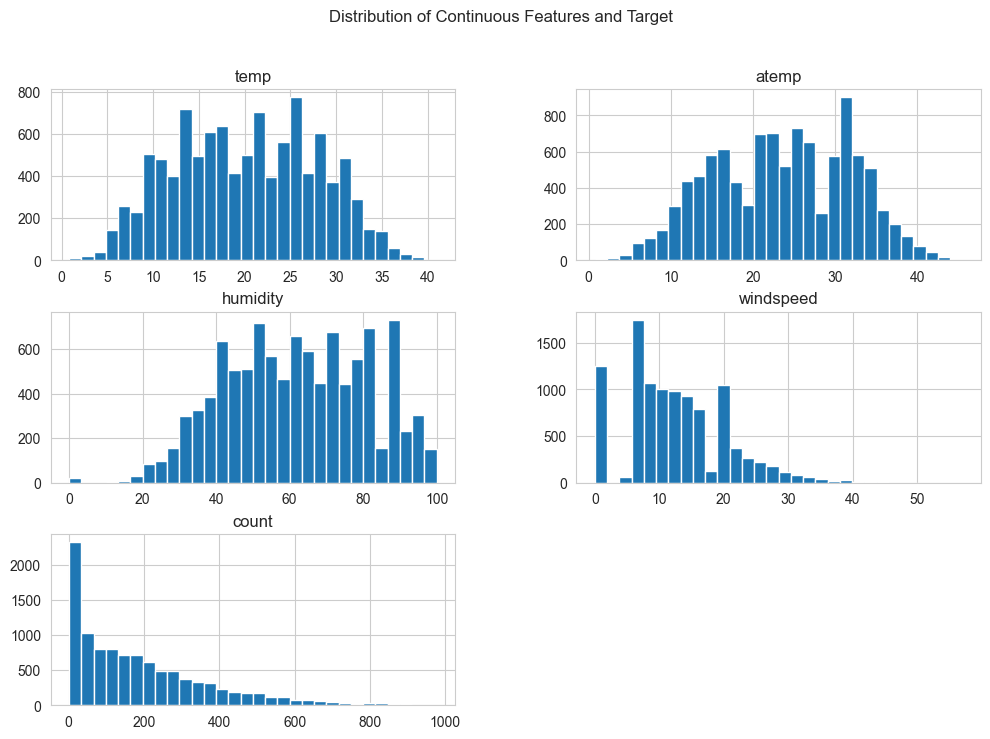

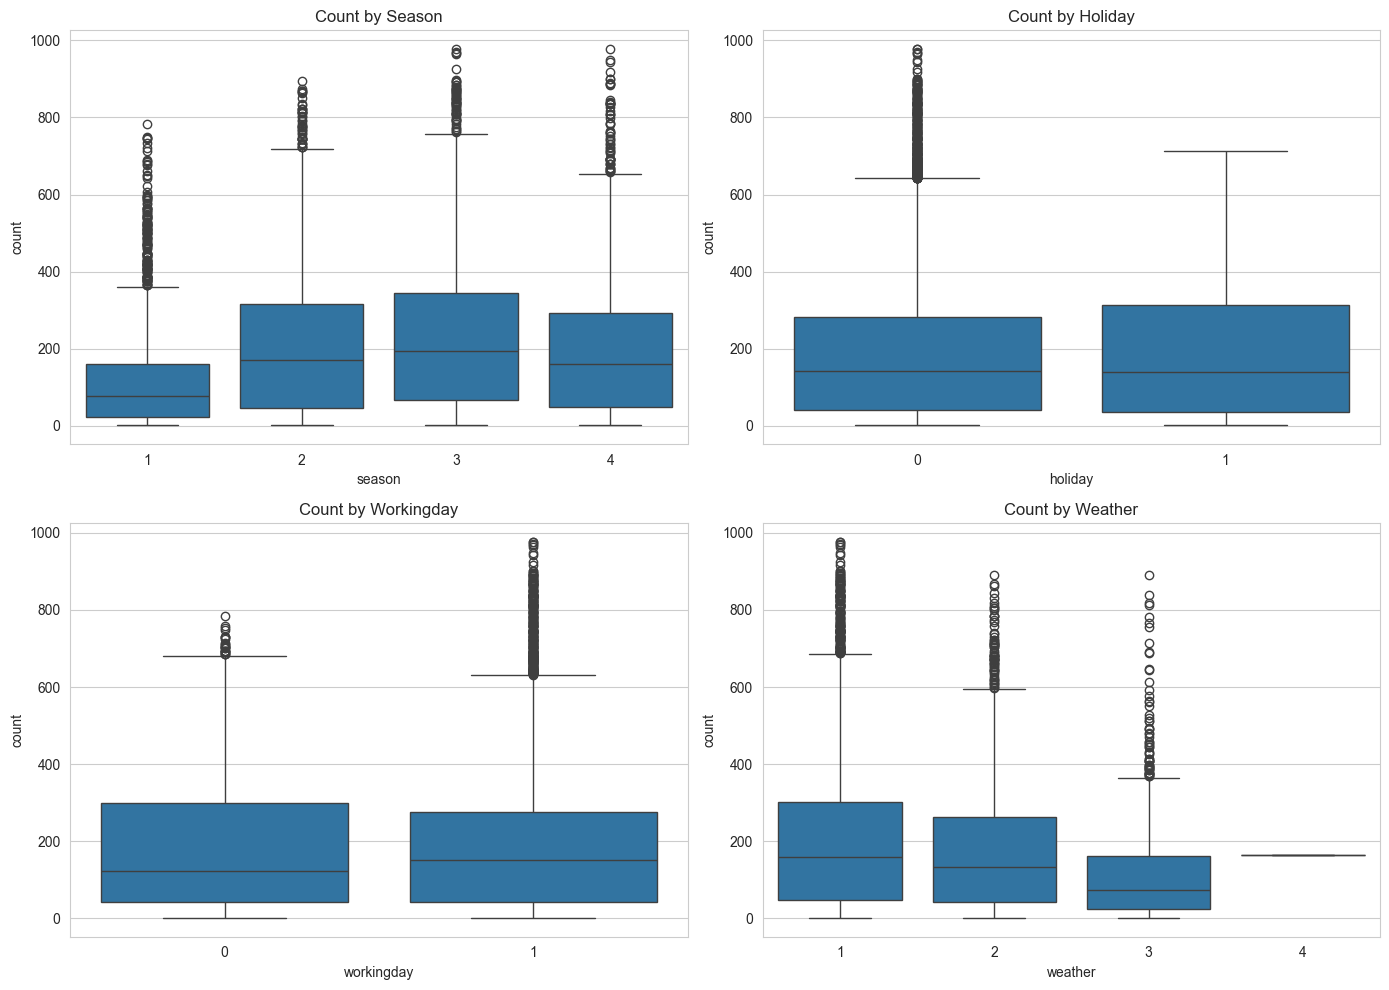

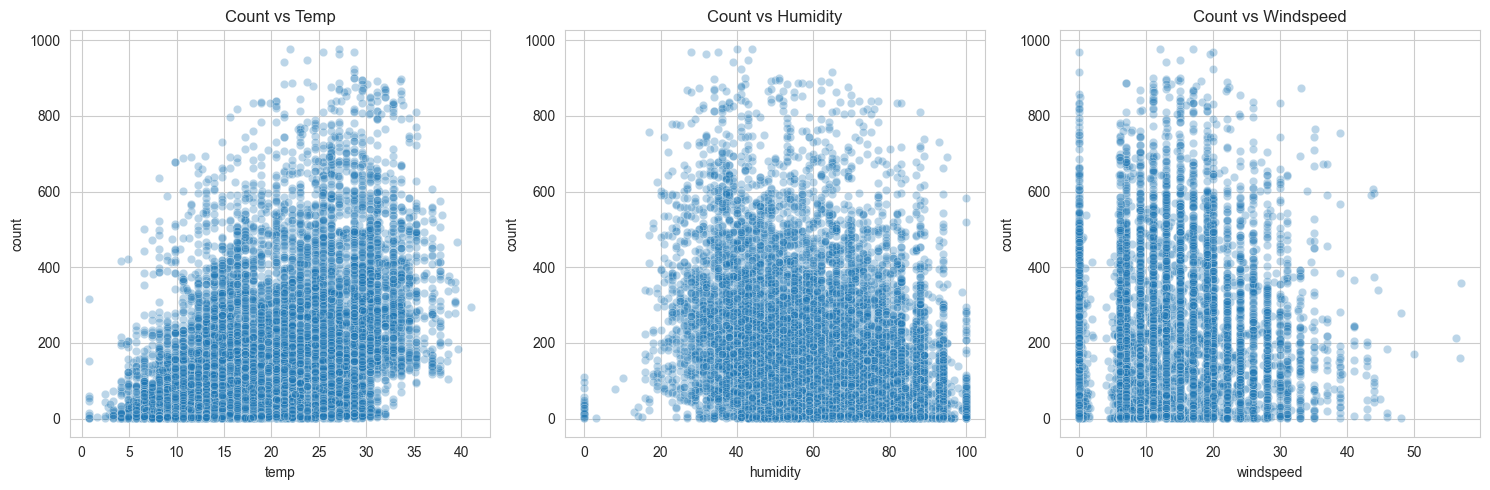

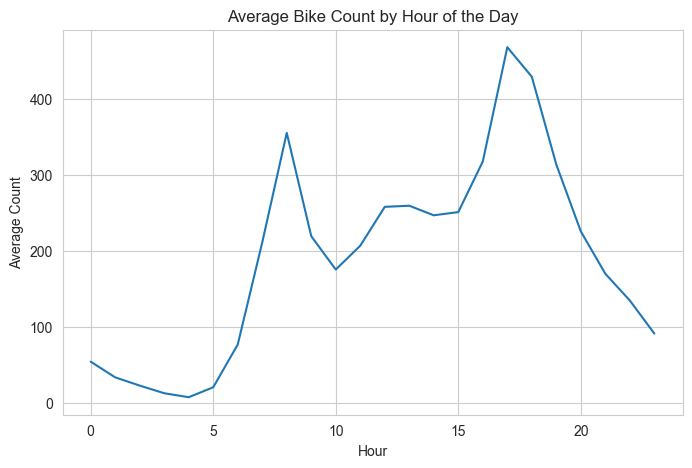

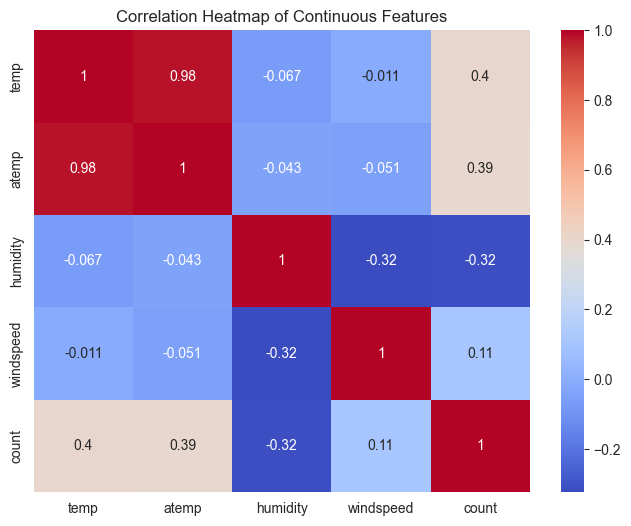

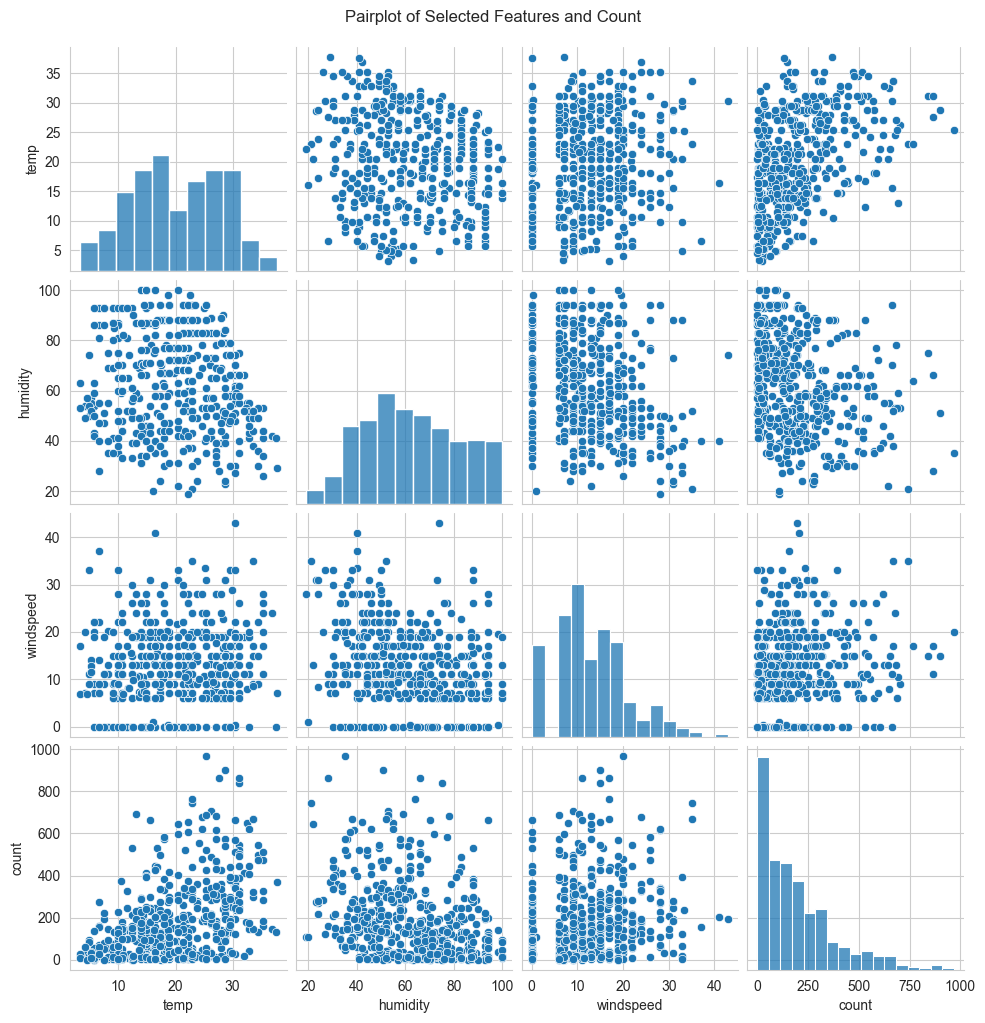

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'datetime_parsed', 'hour', 'day', 'month',
       'year', 'weekday', 'is_weekend', 'temp_feels_diff', 'bad_weather_peak',
       'humid_temp', 'work_hour', 'weekend_hour', 'wind_weather', 'temp_hour',
       'peak_morning', 'peak_evening'],
      dtype='object')
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/var/folders/pd/sd9vp0w55wggcsgz81smzt6c0000gn/T/ipykernel_7828/1411406585.py:67: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  train['datetime_parsed'] = pd.to_datetime(


[CV] END regressor__model__learning_rate=0.01, regressor__model__max_depth=3, regressor__model__min_samples_split=2, regressor__model__n_estimators=100; total time=   1.1s
[CV] END regressor__model__learning_rate=0.01, regressor__model__max_depth=3, regressor__model__min_samples_split=2, regressor__model__n_estimators=100; total time=   1.3s
[CV] END regressor__model__learning_rate=0.01, regressor__model__max_depth=3, regressor__model__min_samples_split=2, regressor__model__n_estimators=100; total time=   1.2s
[CV] END regressor__model__learning_rate=0.01, regressor__model__max_depth=3, regressor__model__min_samples_split=2, regressor__model__n_estimators=100; total time=   1.2s
[CV] END regressor__model__learning_rate=0.01, regressor__model__max_depth=3, regressor__model__min_samples_split=2, regressor__model__n_estimators=100; total time=   1.3s
[CV] END regressor__model__learning_rate=0.01, regressor__model__max_depth=3, regressor__model__min_samples_split=2, regressor__model__n_est

/Users/ps/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.610e+06, tolerance: 2.739e+04
  model = cd_fast.enet_coordinate_descent(


Lasso Polynomial Regression RMSLE: 1.2412067343387858
RandomForest RMSLE: 0.42741529222878544
GradientBoosting (Tuned Log-Transform) RMSLE: 0.3907695506009088
                                    Model     RMSLE
5  GradientBoosting (Tuned Log-Transform)  0.390770
4                            RandomForest  0.427415
2        Polynomial Regression (Degree 2)  0.898676
3             Lasso Polynomial Regression  1.241207
1                                   Ridge  1.258287
0                                  Linear  1.260231


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,...,is_weekend,temp_feels_diff,bad_weather_peak,humid_temp,work_hour,weekend_hour,wind_weather,temp_hour,peak_morning,peak_evening
0,2012-07-15 07:00:00,3,0,0,1,28.70000,33.335000,79,6.003200,47,...,1,-4.635000,7,2267.300000,0,7,6.003200,200.900000,1,0
1,2012-08-14 15:00:00,3,0,1,1,33.62000,37.880000,46,15.001300,283,...,0,-4.260000,15,1546.520000,15,0,15.001300,504.300000,0,0
2,2011-02-06 06:00:00,1,0,0,1,10.66000,12.880000,60,15.001300,1,...,1,-2.220000,6,639.600000,0,6,15.001300,63.960000,0,0
3,2012-05-06 17:00:00,2,0,0,2,26.42506,30.566166,61,9.512288,531,...,1,-4.141106,34,1611.928679,0,17,19.024575,449.226025,0,1
4,2012-01-09 02:00:00,1,0,1,1,9.84000,12.120000,56,8.998100,5,...,0,-2.280000,2,551.040000,2,0,8.998100,19.680000,0,0


In [6]:
# %%
#visualization of data is kept standlone for better readability
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_df = pd.read_csv('bike_train.csv')

# Convert datetime column to datetime type and extract hour and month for temporal analysis
train_df['datetime'] = pd.to_datetime(train_df['datetime'], format='%d/%m/%y %H:%M')
train_df['hour'] = train_df['datetime'].dt.hour
train_df['month'] = train_df['datetime'].dt.month

# Set plotting style
sns.set_style('whitegrid')

# 1. Histograms for continuous features and target
continuous_features = ['temp', 'atemp', 'humidity', 'windspeed', 'count']
train_df[continuous_features].hist(bins=30, figsize=(12, 8))
plt.suptitle('Distribution of Continuous Features and Target')
plt.show()

# 2. Boxplots of count by categorical features
categorical_features = ['season', 'holiday', 'workingday', 'weather']
plt.figure(figsize=(14, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=feature, y='count', data=train_df)
    plt.title(f'Count by {feature.capitalize()}')
plt.tight_layout()
plt.show()

# 3. Scatter plots for continuous features vs count
plt.figure(figsize=(15, 5))
for i, feature in enumerate(['temp', 'humidity', 'windspeed'], 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=feature, y='count', data=train_df, alpha=0.3)
    plt.title(f'Count vs {feature.capitalize()}')
plt.tight_layout()
plt.show()

# 4. Line plot for average count by hour of the day
plt.figure(figsize=(8, 5))
hourly_counts = train_df.groupby('hour')['count'].mean()
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values)
plt.title('Average Bike Count by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Average Count')
plt.show()

# 5. Correlation heatmap for continuous variables
plt.figure(figsize=(8, 6))
corr = train_df[continuous_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Continuous Features')
plt.show()

# 6. Pairplot of key features and count (sample for speed)
sns.pairplot(train_df.sample(500), vars=['temp', 'humidity', 'windspeed', 'count'])
plt.suptitle('Pairplot of Selected Features and Count', y=1.02)
plt.show()


# %%
# Your dataset uses DD/MM/YY HH:MM format, so dayfirst=True is appropriate
train['datetime_parsed'] = pd.to_datetime(
    train['datetime'], 
    dayfirst=True, 
    errors='coerce'
)

test['datetime_parsed'] = pd.to_datetime(
    test['datetime'], 
    dayfirst=True, 
    errors='coerce'
)
#  Extract datetime features
def add_datetime_features(df):
    # Basic time units
    df['hour'] = df['datetime_parsed'].dt.hour
    df['day'] = df['datetime_parsed'].dt.day
    df['month'] = df['datetime_parsed'].dt.month
    df['year'] = df['datetime_parsed'].dt.year
    
    # Monday = 0 ... Sunday = 6
    df['weekday'] = df['datetime_parsed'].dt.weekday
    
    # Weekend flag
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    
    return df


# Apply for both train and test
train = add_datetime_features(train)
test = add_datetime_features(test)

# %%
def add_interaction_features(df):
    df["temp_feels_diff"] = df["temp"] - df["atemp"]
    df["bad_weather_peak"] = df["weather"] * df["hour"]
    df["humid_temp"] = df["humidity"] * df["temp"]
    df["work_hour"] = df["workingday"] * df["hour"]
    df["weekend_hour"] = df["is_weekend"] * df["hour"]
    df["wind_weather"] = df["windspeed"] * df["weather"]
    df["temp_hour"] = df["temp"] * df["hour"]
    df["peak_morning"] = df["hour"].isin([7,8,9]).astype(int)
    df["peak_evening"] = df["hour"].isin([17,18,19]).astype(int)
    return df

train = add_interaction_features(train)
test = add_interaction_features(test)

# %%
#  causal and registered columns are not present in test set, so drop them from train set , also target is to get predicated count , 
# hence dropping these columns will avoid data leakage  
for c in ['casual','registered']:
    if c in train.columns:
        train = train.drop(columns=[c])

# %%

#  Target & base features
y = train['count']
X = train.drop(columns=['count','datetime'])

# %%

# Cyclical encoding of time features
def cyclical_encode(series, period, prefix):
    radians = 2 * np.pi * series / period
    return pd.DataFrame({
        f'{prefix}_sin': np.sin(radians),
        f'{prefix}_cos': np.cos(radians)
    })

# Apply cyclical enc
X_cyc = pd.concat([
    cyclical_encode(X['hour'], 24, 'hour'),
    cyclical_encode(X['month'], 12, 'month'),
    cyclical_encode(X['weekday'], 7, 'weekday')], axis=1)

X_model_fe = X.drop(columns=['hour','day','month','weekday']).reset_index(drop=True)
X_model_fe = pd.concat([X_model_fe, X_cyc.reset_index(drop=True)], axis=1)

# same for test
test_model = test.drop(columns=['datetime']).copy()
test_cyc = pd.concat([
    cyclical_encode(test_model['hour'], 24, 'hour'),
    cyclical_encode(test_model['month'], 12, 'month'),
    cyclical_encode(test_model['weekday'], 7, 'weekday')], axis=1)
test_model = test_model.drop(columns=['hour','day','month','weekday']).reset_index(drop=True)
test_model = pd.concat([test_model, test_cyc.reset_index(drop=True)], axis=1)

# %%
train.head(5)

# %%
# Define columns (adjust if necessary)
numeric_cols = ['temp', 'atemp', 'humidity', 'windspeed', 'year', 'day','temp_feels_diff','bad_weather_peak','humid_temp','work_hour','weekend_hour','wind_weather','temp_hour','peak_morning','peak_evening']
cat_cols = ['season', 'weather', 'holiday', 'workingday', 'is_weekend']

# Preprocessing pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
])




# %%
# Split the data into training and validation sets
#randoem_state=42 for reproducibility
#test_size=0.2 means 20% data will be used for validation
#Q5. Split data into training and validation sets and build a simple Linear Regression model.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
assert not np.any(np.isnan(X_train)), "NaNs found in X_train"
assert not np.any(np.isinf(X_train)), "Infinite values found in X_train"
assert not np.any(np.isnan(y_train)), "NaNs found in y_train"
assert not np.any(np.isinf(y_train)), "Infinite values found in y_train"

# Adjust feature columns to match X_train columns
numeric_cols = [col for col in numeric_cols if col in X_train.columns]
cat_cols = [col for col in cat_cols if col in X_train.columns]

# %%
print(X_train.columns)

# %%
# Define your models dictionary with all models (including polynomial with scaler after poly)
models = {
    'Linear': Pipeline([
        ('pre', preprocessor), 
        ('model', LinearRegression())
    ]),
    'Ridge': Pipeline([
        ('pre', preprocessor), 
        ('model', RidgeCV(alphas=[0.1,1.0,10.0]))
    ]),
    'Polynomial Regression (Degree 2)': Pipeline([
        ('pre', preprocessor),
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('scaler', StandardScaler()),  # ITSR fine tuning
        ('model', RidgeCV(alphas=[0.1, 1.0, 10.0]))
    ]),
    'Lasso Polynomial Regression': Pipeline([
        ('pre', preprocessor),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),  # ITSR fine tuning
        ('model', Lasso(alpha=0.001, max_iter=20000))  # Increased max_iter, ITSR fine tuning
    ]),
    'RandomForest': Pipeline([
        ('pre', preprocessor), 
        ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
    ]),
    # GradientBoosting wrapped with log-transform for further tuning added below
}

# %%
#tuning: Wrap GradientBoosting with TransformedTargetRegressor for log-transform of target
from sklearn.compose import TransformedTargetRegressor

gb_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

regressor_log = TransformedTargetRegressor(
    regressor=gb_pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

# Add tuned GradientBoosting regressors to models dict for easy access if needed
models['GradientBoosting (Tuned Log-Transform)'] = regressor_log

# Hyperparameter tuning for the GradientBoosting regressor with log-transform target
param_grid = {
    'regressor__model__n_estimators': [100, 200, 300],
    'regressor__model__max_depth': [3, 4, 5],
    'regressor__model__learning_rate': [0.01, 0.1, 0.2],
    'regressor__model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    regressor_log,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_log_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)


#print("Best parameters for GradientBoosting:", grid_search.best_params_)

best_gb_model = grid_search.best_estimator_

# %%
results = {}
warnings.filterwarnings
for name, pipe in models.items():
    if name == 'GradientBoosting (Tuned Log-Transform)':
        # Use the best tuned Gradient Boosting model
        y_pred = best_gb_model.predict(X_val)
    
    else:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_val)
    score = rmsle(y_val, y_pred)
    results[name] = score
    print(f"{name} RMSLE: {score}")

# Convert results dictionary to DataFrame and display
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSLE']).sort_values(by='RMSLE')
print(results_df)

# %%
X_test=test
train.head(5)



# %%

In [7]:
#submission output
test_preds = best_gb_model.predict(X_test)
test_preds = np.where(test_preds < 0, 0, test_preds)
test_preds_rounded = np.round(test_preds).astype(int)

submission = pd.DataFrame({
    'datetime': pd.to_datetime(
        test['datetime'], 
        format='%d-%m-%Y %H:%M'
    ).dt.strftime('%Y-%m-%d %H:%M:%S'),
    'count_predicted': test_preds_rounded
})

submission.to_csv('submission.csv', index=False)
print("Saved submission to submission.csv")

ValueError: time data "2012-06-05 05:00:00" doesn't match format "%d-%m-%Y %H:%M", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [8]:
#submission output
test_preds = best_gb_model.predict(X_test)
test_preds = np.where(test_preds < 0, 0, test_preds)
test_preds_rounded = np.round(test_preds).astype(int)

submission = pd.DataFrame({
    'datetime': pd.to_datetime(
        test['datetime']),
    'count_predicted': test_preds_rounded
})

submission.to_csv('submission.csv', index=False)
print("Saved submission to submission.csv")

Saved submission to submission.csv


In [9]:
submission.head(5)

,datetime,count_predicted
0,2012-06-05 05:00:00,16
1,2011-03-19 19:00:00,238
2,2012-04-02 06:00:00,107
3,2012-07-13 20:00:00,289
4,2011-11-09 19:00:00,193


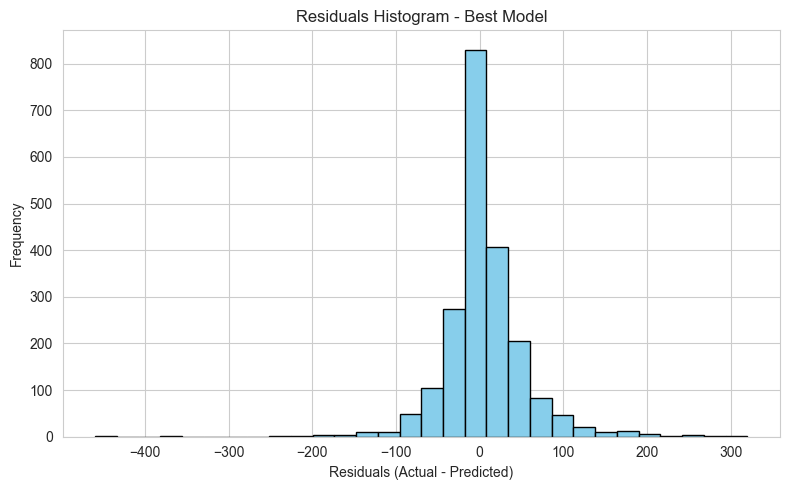

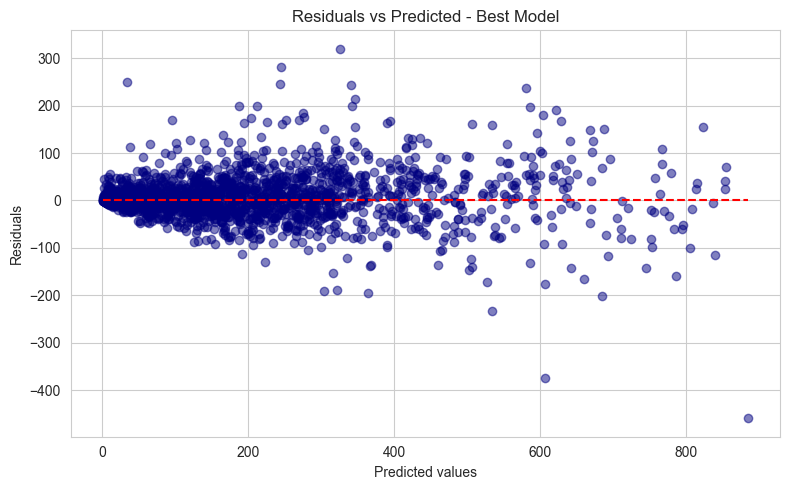

In [10]:
import matplotlib.pyplot as plt

# Assume best_gb_model is your best model after tuning
y_val_pred = best_gb_model.predict(X_val)

# Calculate residuals (actual - predicted)
residuals = y_val - y_val_pred

# Plot residuals histogram
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title('Residuals Histogram - Best Model')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Optional: Scatter plot of predicted vs residuals to check for patterns
plt.figure(figsize=(8, 5))
plt.scatter(y_val_pred, residuals, alpha=0.5, color='navy')
plt.hlines(y=0, xmin=min(y_val_pred), xmax=max(y_val_pred), colors='red', linestyles='dashed')
plt.title('Residuals vs Predicted - Best Model')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()
